# LEARN TO RACE: GPU-Accelerated Imitation Learning

## High-Performance Neural Racing Policy with cuProx

This notebook demonstrates:
- Procedural race track generation with complex geometry
- Expert MPC-like driver generating demonstrations
- Neural network policy trained via imitation learning
- GPU-accelerated batch QP solving benchmark
- Beautiful animated racing visualization

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import LineCollection
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
import time
from dataclasses import dataclass
from typing import List, Tuple
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, '../python')
import cuprox

plt.style.use('dark_background')
plt.rcParams.update({'figure.facecolor': '#0a0a0f', 'axes.facecolor': '#0f0f18', 'font.family': 'monospace'})
C = {'blue': '#00f0ff', 'pink': '#ff00aa', 'green': '#00ff88', 'orange': '#ff8800', 'purple': '#aa00ff', 'yellow': '#ffff00', 'red': '#ff0044', 'white': '#ffffff', 'gray': '#444466'}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64

print('='*70)
print('  LEARN TO RACE - GPU-Accelerated Imitation Learning')
print('='*70)
if torch.cuda.is_available():
    gpu = torch.cuda.get_device_properties(0)
    print(f'  GPU: {gpu.name} ({gpu.total_memory/1e9:.1f} GB)')
print(f'  cuProx: {cuprox.__version__}')
print('='*70)
np.random.seed(42)
torch.manual_seed(42)

  LEARN TO RACE - GPU-Accelerated Imitation Learning
  GPU: NVIDIA RTX A6000 (50.9 GB)
  cuProx: 0.1.0


## 1. Race Track Generation

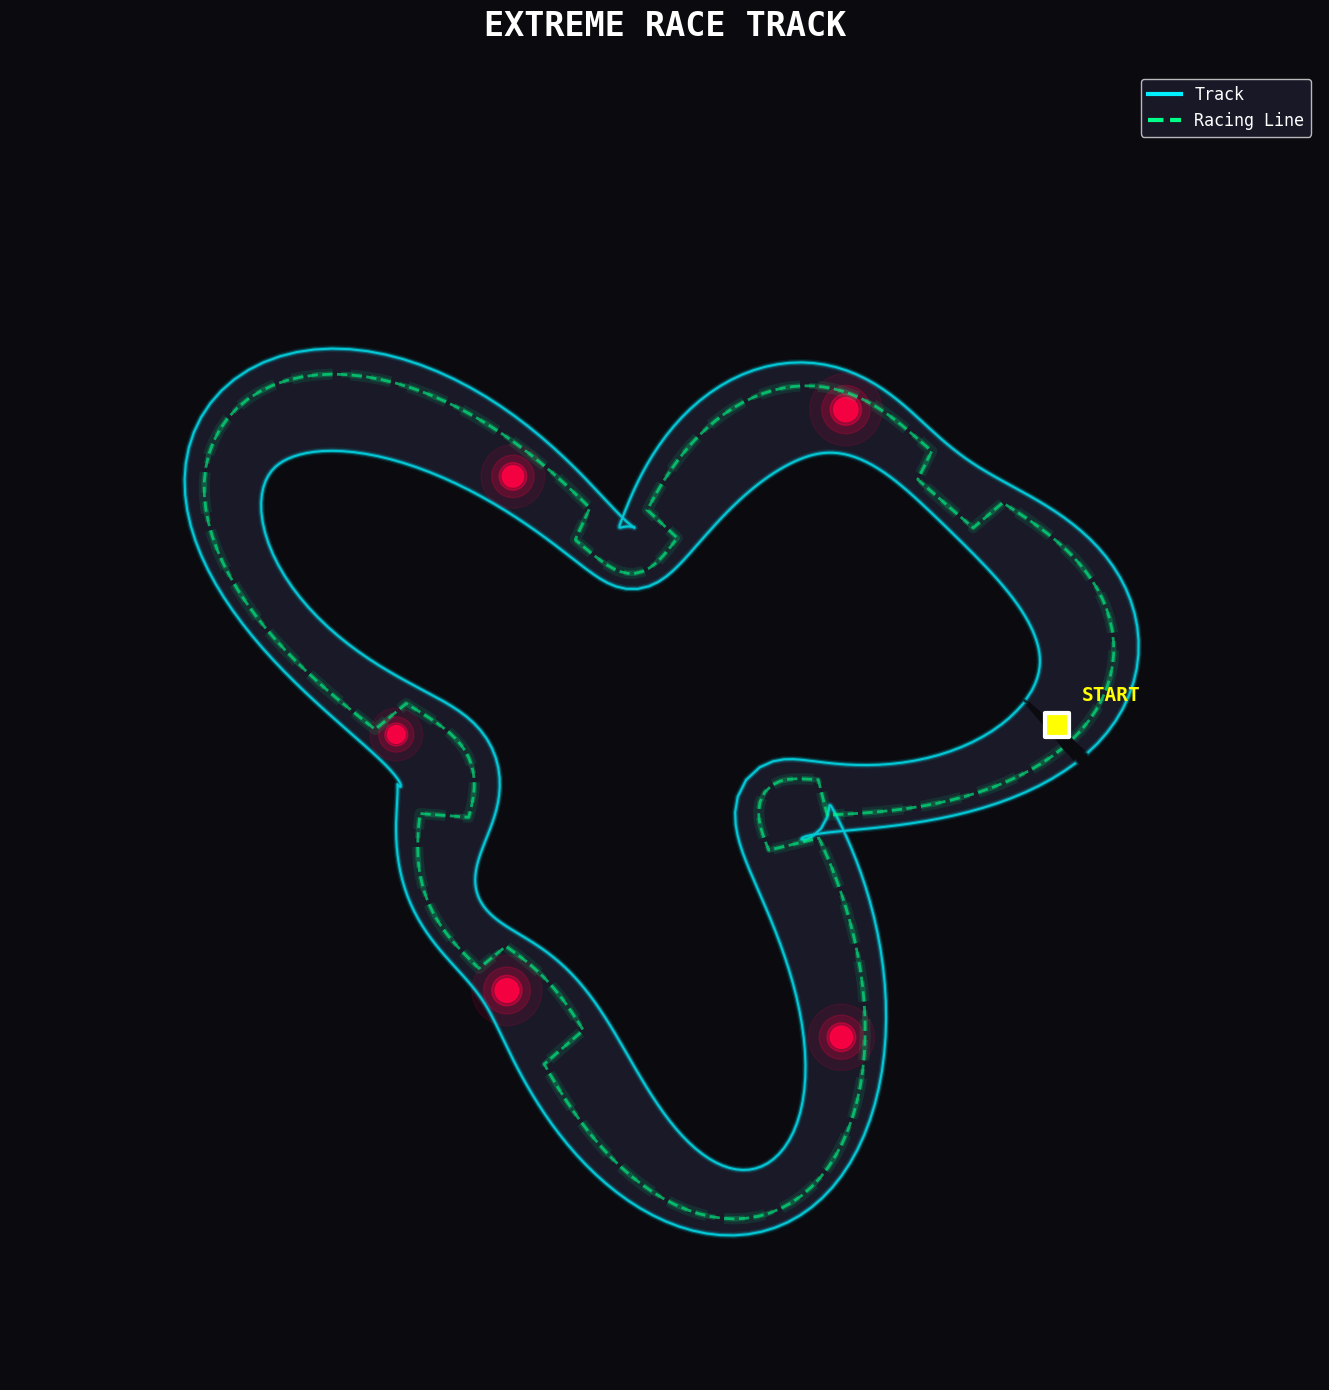

Track: 300 pts, 5 obstacles


In [2]:
@dataclass
class RaceTrack:
    centerline: np.ndarray
    inner_boundary: np.ndarray
    outer_boundary: np.ndarray
    racing_line: np.ndarray
    width: np.ndarray
    obstacles: List[Tuple[float, float, float]]

def generate_track(n_pts=300):
    t = np.linspace(0, 2*np.pi, n_pts, endpoint=False)
    r = 4 + 1.5*np.sin(3*t) + 0.8*np.cos(5*t)
    center = np.stack([r*np.cos(t), r*np.sin(t)], axis=1)
    
    tangents = np.gradient(center, axis=0)
    tangents /= np.linalg.norm(tangents, axis=1, keepdims=True) + 1e-8
    normals = np.stack([-tangents[:, 1], tangents[:, 0]], axis=1)
    
    width = 1.0 + 0.25*np.sin(6*t)
    inner = center - normals * width[:, None] / 2
    outer = center + normals * width[:, None] / 2
    
    curv = np.gradient(np.gradient(center, axis=0), axis=0)
    curv_sign = np.sign(np.sum(curv * normals, axis=1))
    racing = center + normals * (-0.25 * width * curv_sign)[:, None]
    
    obstacles = []
    for idx in [n_pts//6, n_pts//3, n_pts//2, 2*n_pts//3, 5*n_pts//6]:
        pos = center[idx] + normals[idx] * (np.random.rand()-0.5) * width[idx] * 0.4
        obstacles.append((float(pos[0]), float(pos[1]), 0.1 + 0.05*np.random.rand()))
    
    return RaceTrack(center, inner, outer, racing, width, obstacles)

track = generate_track(300)

fig, ax = plt.subplots(figsize=(14, 14))
poly = np.vstack([track.outer_boundary, track.inner_boundary[::-1]])
ax.fill(poly[:, 0], poly[:, 1], color='#1a1a2a', alpha=0.95)
for w, a in [(5, 0.1), (3, 0.3), (1.5, 0.7)]:
    ax.plot(track.inner_boundary[:, 0], track.inner_boundary[:, 1], color=C['blue'], lw=w, alpha=a)
    ax.plot(track.outer_boundary[:, 0], track.outer_boundary[:, 1], color=C['blue'], lw=w, alpha=a)
for w, a in [(8, 0.1), (4, 0.2), (2, 0.6)]:
    ax.plot(track.racing_line[:, 0], track.racing_line[:, 1], color=C['green'], lw=w, alpha=a, ls='--')
for x, y, r in track.obstacles:
    for rm, alpha in [(3, 0.1), (2, 0.2), (1.3, 0.4), (1.0, 0.9)]:
        ax.add_patch(Circle((x, y), r*rm, color=C['red'], alpha=alpha))
ax.scatter([track.centerline[0, 0]], [track.centerline[0, 1]], s=300, c=C['yellow'], marker='s', zorder=10, edgecolors='white', lw=3)
ax.annotate('START', track.centerline[0] + [0.3, 0.3], color=C['yellow'], fontsize=14, fontweight='bold')
ax.set_aspect('equal'); ax.set_xlim(-8, 8); ax.set_ylim(-8, 8); ax.axis('off')
ax.set_title('EXTREME RACE TRACK', fontsize=24, fontweight='bold', color=C['white'], pad=25)
ax.legend([plt.Line2D([0],[0], color=C['blue'], lw=3), plt.Line2D([0],[0], color=C['green'], lw=3, ls='--')], ['Track', 'Racing Line'], loc='upper right', fontsize=12, framealpha=0.9, facecolor='#1a1a2a')
plt.tight_layout()
plt.savefig('racing_track.png', dpi=150, bbox_inches='tight', facecolor='#0a0a0f')
plt.show()
print(f'Track: {len(track.centerline)} pts, {len(track.obstacles)} obstacles')

## 2. Vehicle Dynamics & Expert Driver

Generating expert...
Generated 801 states


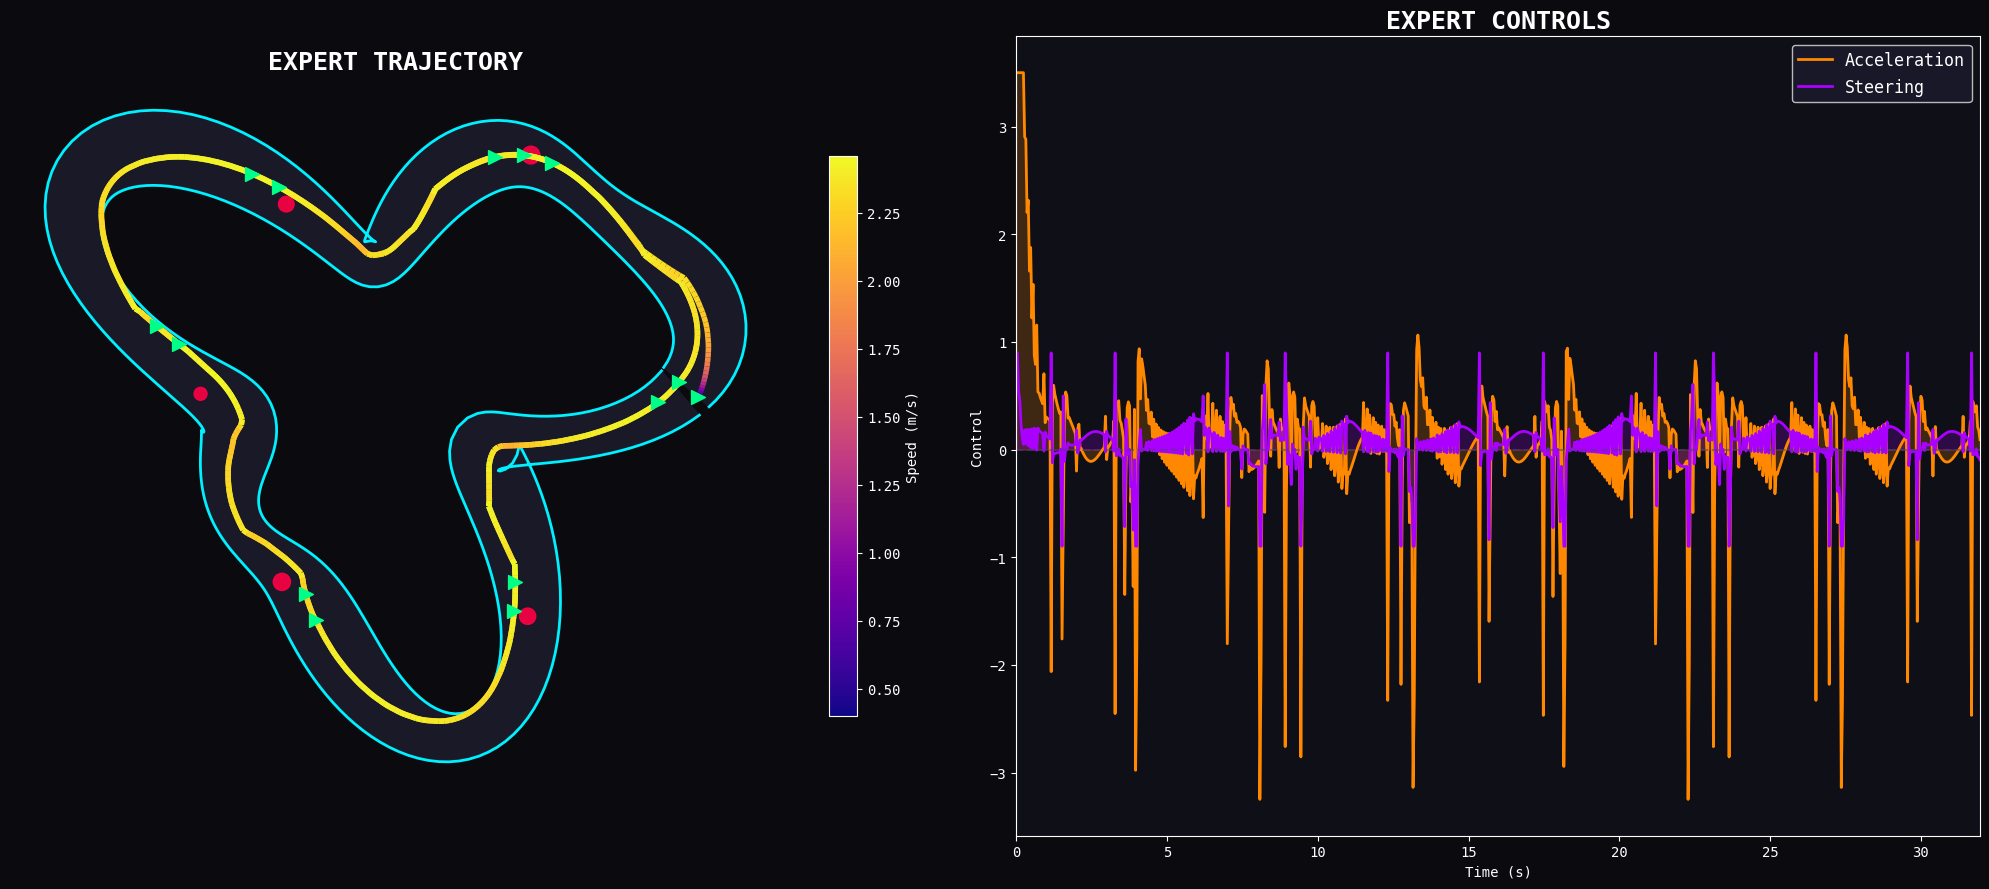

In [3]:
@dataclass
class State:
    x: float; y: float; theta: float; v: float
    def arr(self): return np.array([self.x, self.y, self.theta, self.v])

class Dynamics:
    def __init__(self, dt=0.04):
        self.dt, self.L = dt, 0.25
        self.v_max, self.v_min, self.a_max, self.d_max = 4.0, 0.4, 3.5, np.pi/3.5
    def step(self, s, a, d):
        a, d = np.clip(a, -self.a_max, self.a_max), np.clip(d, -self.d_max, self.d_max)
        v = np.clip(s.v + a*self.dt, self.v_min, self.v_max)
        th = s.theta + (v/self.L)*np.tan(d)*self.dt
        return State(s.x + v*np.cos(th)*self.dt, s.y + v*np.sin(th)*self.dt, th, v)

class Expert:
    def __init__(self, track, dyn):
        self.track, self.dyn = track, dyn
    def control(self, s):
        pos = np.array([s.x, s.y])
        idx = np.argmin(np.linalg.norm(self.track.racing_line - pos, axis=1))
        target = self.track.racing_line[(idx + 10) % len(self.track.racing_line)]
        dx, dy = target - pos
        target_th = np.arctan2(dy, dx)
        err = np.arctan2(np.sin(target_th - s.theta), np.cos(target_th - s.theta))
        steer = np.clip(3.0*err, -self.dyn.d_max, self.dyn.d_max)
        target_v = 2.5 * (1 - 0.5*np.tanh(abs(err)*2))
        accel = np.clip(3.0*(target_v - s.v), -self.dyn.a_max, self.dyn.a_max)
        return accel, steer

dyn = Dynamics(dt=0.04)
expert = Expert(track, dyn)

def gen_expert(track, n=600):
    p0, p1 = track.racing_line[0], track.racing_line[1]
    s = State(p0[0], p0[1], np.arctan2(p1[1]-p0[1], p1[0]-p0[0]), dyn.v_min)
    states, ctrls = [s.arr()], []
    for _ in range(n):
        a, d = expert.control(s)
        ctrls.append([a, d])
        s = dyn.step(s, a, d)
        states.append(s.arr())
    return {'states': np.array(states), 'controls': np.array(ctrls)}

print('Generating expert...')
exp_data = gen_expert(track, 800)
print(f'Generated {len(exp_data["states"])} states')

fig, axes = plt.subplots(1, 2, figsize=(20, 9))
ax = axes[0]
poly = np.vstack([track.outer_boundary, track.inner_boundary[::-1]])
ax.fill(poly[:, 0], poly[:, 1], color='#1a1a2a', alpha=0.95)
ax.plot(track.inner_boundary[:, 0], track.inner_boundary[:, 1], color=C['blue'], lw=2)
ax.plot(track.outer_boundary[:, 0], track.outer_boundary[:, 1], color=C['blue'], lw=2)
traj = exp_data['states']
pts = traj[:, :2].reshape(-1, 1, 2)
segs = np.concatenate([pts[:-1], pts[1:]], axis=1)
lc = LineCollection(segs, cmap='plasma', lw=4)
lc.set_array(traj[:-1, 3])
ax.add_collection(lc)
plt.colorbar(lc, ax=ax, label='Speed (m/s)', shrink=0.7)
for x, y, r in track.obstacles:
    ax.add_patch(Circle((x, y), r, color=C['red'], alpha=0.9))
for i in range(0, len(traj), 60):
    ax.scatter(traj[i, 0], traj[i, 1], s=100, c=C['green'], marker='>', zorder=10)
ax.set_aspect('equal'); ax.axis('off')
ax.set_title('EXPERT TRAJECTORY', fontsize=18, fontweight='bold', color=C['white'])

ax = axes[1]
t = np.arange(len(exp_data['controls'])) * dyn.dt
ax.plot(t, exp_data['controls'][:, 0], color=C['orange'], lw=2, label='Acceleration')
ax.plot(t, exp_data['controls'][:, 1], color=C['purple'], lw=2, label='Steering')
ax.axhline(0, color=C['gray'], ls='--', alpha=0.5)
ax.fill_between(t, 0, exp_data['controls'][:, 0], alpha=0.2, color=C['orange'])
ax.fill_between(t, 0, exp_data['controls'][:, 1], alpha=0.2, color=C['purple'])
ax.set_xlabel('Time (s)'); ax.set_ylabel('Control')
ax.set_title('EXPERT CONTROLS', fontsize=18, fontweight='bold', color=C['white'])
ax.legend(fontsize=12, framealpha=0.9, facecolor='#1a1a2a')
ax.set_xlim(0, t[-1])
plt.tight_layout()
plt.savefig('expert_demo.png', dpi=150, bbox_inches='tight', facecolor='#0a0a0f')
plt.show()

## 3. GPU Batch QP Benchmark

  GPU BATCH QP SOLVING BENCHMARK
    100 QPs |     59.8ms | 1,671 QPs/sec


    500 QPs |    298.1ms | 1,677 QPs/sec


   1000 QPs |    600.6ms | 1,665 QPs/sec


   2000 QPs |   1192.2ms | 1,678 QPs/sec


   5000 QPs |   2972.6ms | 1,682 QPs/sec


  10000 QPs |   6025.3ms | 1,660 QPs/sec
  PEAK THROUGHPUT: 1,682 QPs/second


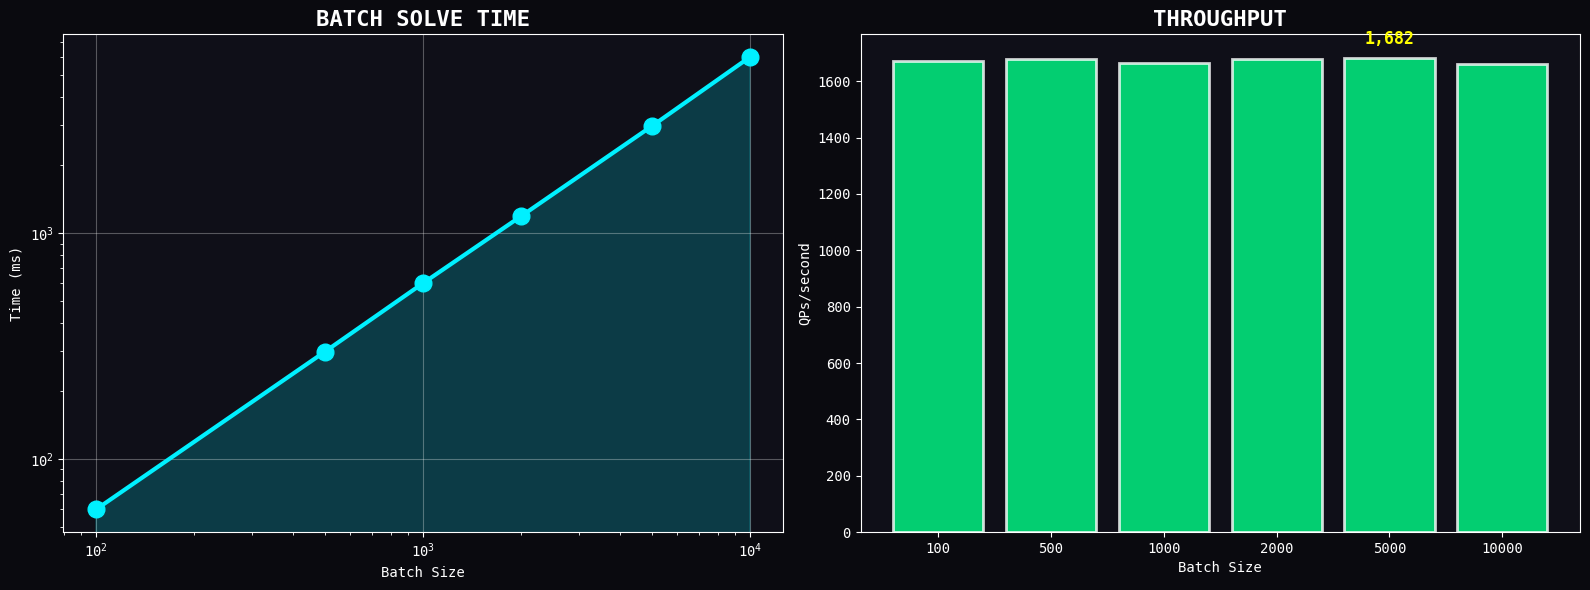

In [4]:
print('='*70)
print('  GPU BATCH QP SOLVING BENCHMARK')
print('='*70)

results = []
batch_sizes = [100, 500, 1000, 2000, 5000, 10000]
n_vars = 20

# Build a batch of QPs
for bs in batch_sizes:
    # Create batch of problems
    problems = []
    for _ in range(bs):
        P = np.eye(n_vars) + 0.1 * np.random.randn(n_vars, n_vars)
        P = P @ P.T
        c = np.random.randn(n_vars)
        lb = -np.ones(n_vars)
        ub = np.ones(n_vars)
        problems.append({'P': P, 'c': c, 'lb': lb, 'ub': ub})
    
    # Warmup
    for p in problems[:5]:
        cuprox.solve(c=p['c'], P=p['P'], lb=p['lb'], ub=p['ub'], params={'max_iterations': 50})
    
    t0 = time.perf_counter()
    for p in problems:
        cuprox.solve(c=p['c'], P=p['P'], lb=p['lb'], ub=p['ub'], params={'max_iterations': 100})
    elapsed = time.perf_counter() - t0
    
    qps = bs / elapsed
    results.append({'batch': bs, 'time': elapsed*1000, 'qps': qps})
    print(f'  {bs:5d} QPs | {elapsed*1000:8.1f}ms | {qps:,.0f} QPs/sec')

peak_qps = max(r['qps'] for r in results)
print('='*70)
print(f'  PEAK THROUGHPUT: {peak_qps:,.0f} QPs/second')
print('='*70)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
batches = [r['batch'] for r in results]
times = [r['time'] for r in results]
qps_list = [r['qps'] for r in results]

ax = axes[0]
ax.loglog(batches, times, 'o-', color=C['blue'], lw=3, markersize=12)
ax.fill_between(batches, times, alpha=0.2, color=C['blue'])
ax.set_xlabel('Batch Size'); ax.set_ylabel('Time (ms)')
ax.set_title('BATCH SOLVE TIME', fontsize=16, fontweight='bold', color=C['white'])
ax.grid(True, alpha=0.3)

ax = axes[1]
bars = ax.bar(range(len(batches)), qps_list, color=C['green'], alpha=0.8, edgecolor='white', lw=2)
ax.set_xticks(range(len(batches)))
ax.set_xticklabels([str(b) for b in batches])
ax.set_xlabel('Batch Size'); ax.set_ylabel('QPs/second')
ax.set_title('THROUGHPUT', fontsize=16, fontweight='bold', color=C['white'])
peak_idx = qps_list.index(max(qps_list))
ax.annotate(f'{peak_qps:,.0f}', (peak_idx, qps_list[peak_idx]), textcoords='offset points', xytext=(0, 10), ha='center', fontsize=12, fontweight='bold', color=C['yellow'])
plt.tight_layout()
plt.savefig('gpu_benchmark.png', dpi=150, bbox_inches='tight', facecolor='#0a0a0f')
plt.show()

## 4. Neural Racing Policy

In [5]:
horizon = 8

class RacingPolicy(nn.Module):
    def __init__(self, h=8, hidden=256):
        super().__init__()
        self.h = h
        # Input: state(4) + waypoints(h*2) = 4 + 16 = 20
        self.net = nn.Sequential(
            nn.Linear(4 + h*2, hidden), nn.LayerNorm(hidden), nn.GELU(),
            nn.Linear(hidden, hidden), nn.LayerNorm(hidden), nn.GELU(),
            nn.Linear(hidden, hidden//2), nn.LayerNorm(hidden//2), nn.GELU(),
            nn.Linear(hidden//2, 2))  # Output: [accel, steer] for first step
    
    def forward(self, state, wp):
        # state: (batch, 4), wp: (batch, h, 2)
        batch = state.shape[0]
        x = torch.cat([state.float(), wp.view(batch, -1).float()], dim=-1)
        out = self.net(x)
        out[:, 0] = torch.tanh(out[:, 0]) * dyn.a_max
        out[:, 1] = torch.tanh(out[:, 1]) * dyn.d_max
        return out

class Dataset:
    def __init__(self, track, data, h):
        self.samples = []
        states, ctrls = data['states'], data['controls']
        for i in range(len(ctrls)):
            pos = states[i][:2]
            idx = np.argmin(np.linalg.norm(track.racing_line - pos, axis=1))
            wp = track.racing_line[[(idx + j*3) % len(track.racing_line) for j in range(h)]]
            self.samples.append({'state': states[i], 'wp': wp, 'ctrl': ctrls[i]})
    
    def batch(self, n, dev):
        idx = np.random.choice(len(self.samples), n, replace=False)
        return {
            'state': torch.tensor(np.array([self.samples[i]['state'] for i in idx]), device=dev, dtype=torch.float32),
            'wp': torch.tensor(np.array([self.samples[i]['wp'] for i in idx]), device=dev, dtype=torch.float32),
            'ctrl': torch.tensor(np.array([self.samples[i]['ctrl'] for i in idx]), device=dev, dtype=torch.float32)
        }
    def __len__(self): return len(self.samples)

dataset = Dataset(track, exp_data, horizon)
model = RacingPolicy(h=horizon, hidden=256).to(device)
print(f'Dataset: {len(dataset)} samples, Model: {sum(p.numel() for p in model.parameters()):,} params')

Dataset: 800 samples, Model: 105,602 params


  TRAINING NEURAL RACING POLICY


  Epoch  50 | Loss: 0.4911 | LR: 0.000300


  Epoch 100 | Loss: 0.3424 | LR: 0.000150


  Epoch 150 | Loss: 0.3103 | LR: 0.000300


  Epoch 200 | Loss: 0.3148 | LR: 0.000256


  Epoch 250 | Loss: 0.2281 | LR: 0.000150


  Epoch 300 | Loss: 0.2651 | LR: 0.000044
  Done in 2.9s, Final loss: 0.2651


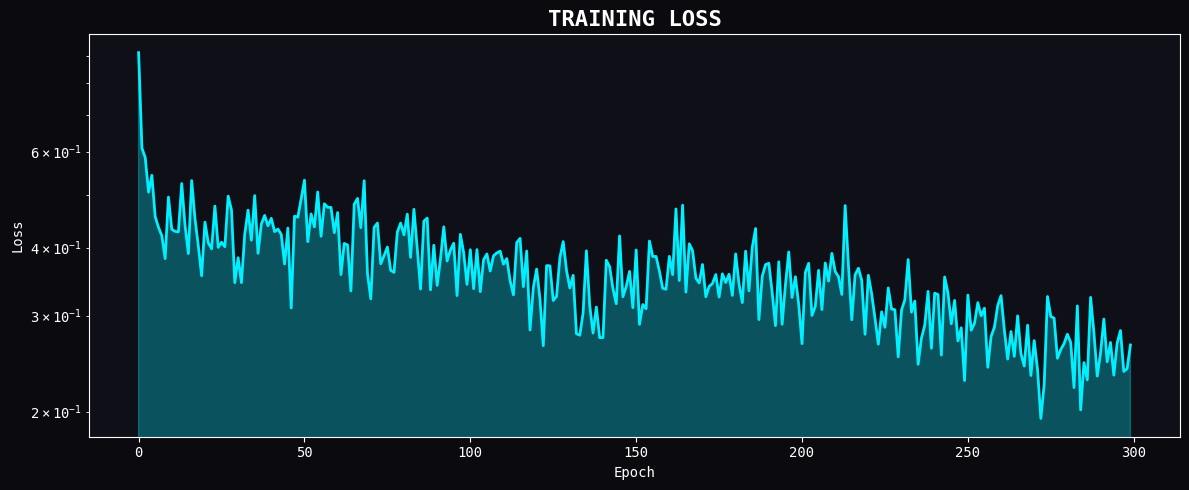

In [6]:
opt = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
sched = optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=50, T_mult=2)
n_epochs, bs = 300, 128
losses = []

print('='*70)
print('  TRAINING NEURAL RACING POLICY')
print('='*70)
t0 = time.time()

for ep in range(n_epochs):
    model.train()
    ep_loss = 0
    n_batch = max(1, len(dataset) // bs)
    for _ in range(n_batch):
        b = dataset.batch(min(bs, len(dataset)), device)
        opt.zero_grad()
        pred = model(b['state'], b['wp'])
        # Weight steering more than acceleration
        a_loss = ((pred[:, 0] - b['ctrl'][:, 0])**2).mean()
        s_loss = ((pred[:, 1] - b['ctrl'][:, 1])**2).mean()
        loss = a_loss + 3*s_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        ep_loss += loss.item()
    sched.step()
    losses.append(ep_loss/n_batch)
    if (ep+1) % 50 == 0:
        print(f'  Epoch {ep+1:3d} | Loss: {losses[-1]:.4f} | LR: {sched.get_last_lr()[0]:.6f}')

train_time = time.time() - t0
print('='*70)
print(f'  Done in {train_time:.1f}s, Final loss: {losses[-1]:.4f}')
print('='*70)

fig, ax = plt.subplots(figsize=(12, 5))
ax.semilogy(losses, color=C['blue'], lw=2)
ax.fill_between(range(len(losses)), losses, alpha=0.3, color=C['blue'])
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('TRAINING LOSS', fontsize=16, fontweight='bold', color=C['white'])
plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight', facecolor='#0a0a0f')
plt.show()

## 5. Evaluation

In [7]:
def rollout(model, track, n=600):
    model.eval()
    p0, p1 = track.racing_line[0], track.racing_line[1]
    s = State(p0[0], p0[1], np.arctan2(p1[1]-p0[1], p1[0]-p0[0]), dyn.v_min)
    states, ctrls = [s.arr()], []
    with torch.no_grad():
        for _ in range(n):
            pos = np.array([s.x, s.y])
            idx = np.argmin(np.linalg.norm(track.racing_line - pos, axis=1))
            wp = track.racing_line[[(idx + j*3) % len(track.racing_line) for j in range(horizon)]]
            st = torch.tensor(s.arr(), device=device, dtype=torch.float32).unsqueeze(0)
            wpt = torch.tensor(wp, device=device, dtype=torch.float32).unsqueeze(0)
            pred = model(st, wpt)
            a, d = pred[0, 0].item(), pred[0, 1].item()
            ctrls.append([a, d])
            s = dyn.step(s, a, d)
            states.append(s.arr())
    return {'states': np.array(states), 'controls': np.array(ctrls)}

print('Rolling out learned policy...')
learned = rollout(model, track, 800)
print(f'Generated {len(learned["states"])} states')

Rolling out learned policy...


Generated 801 states


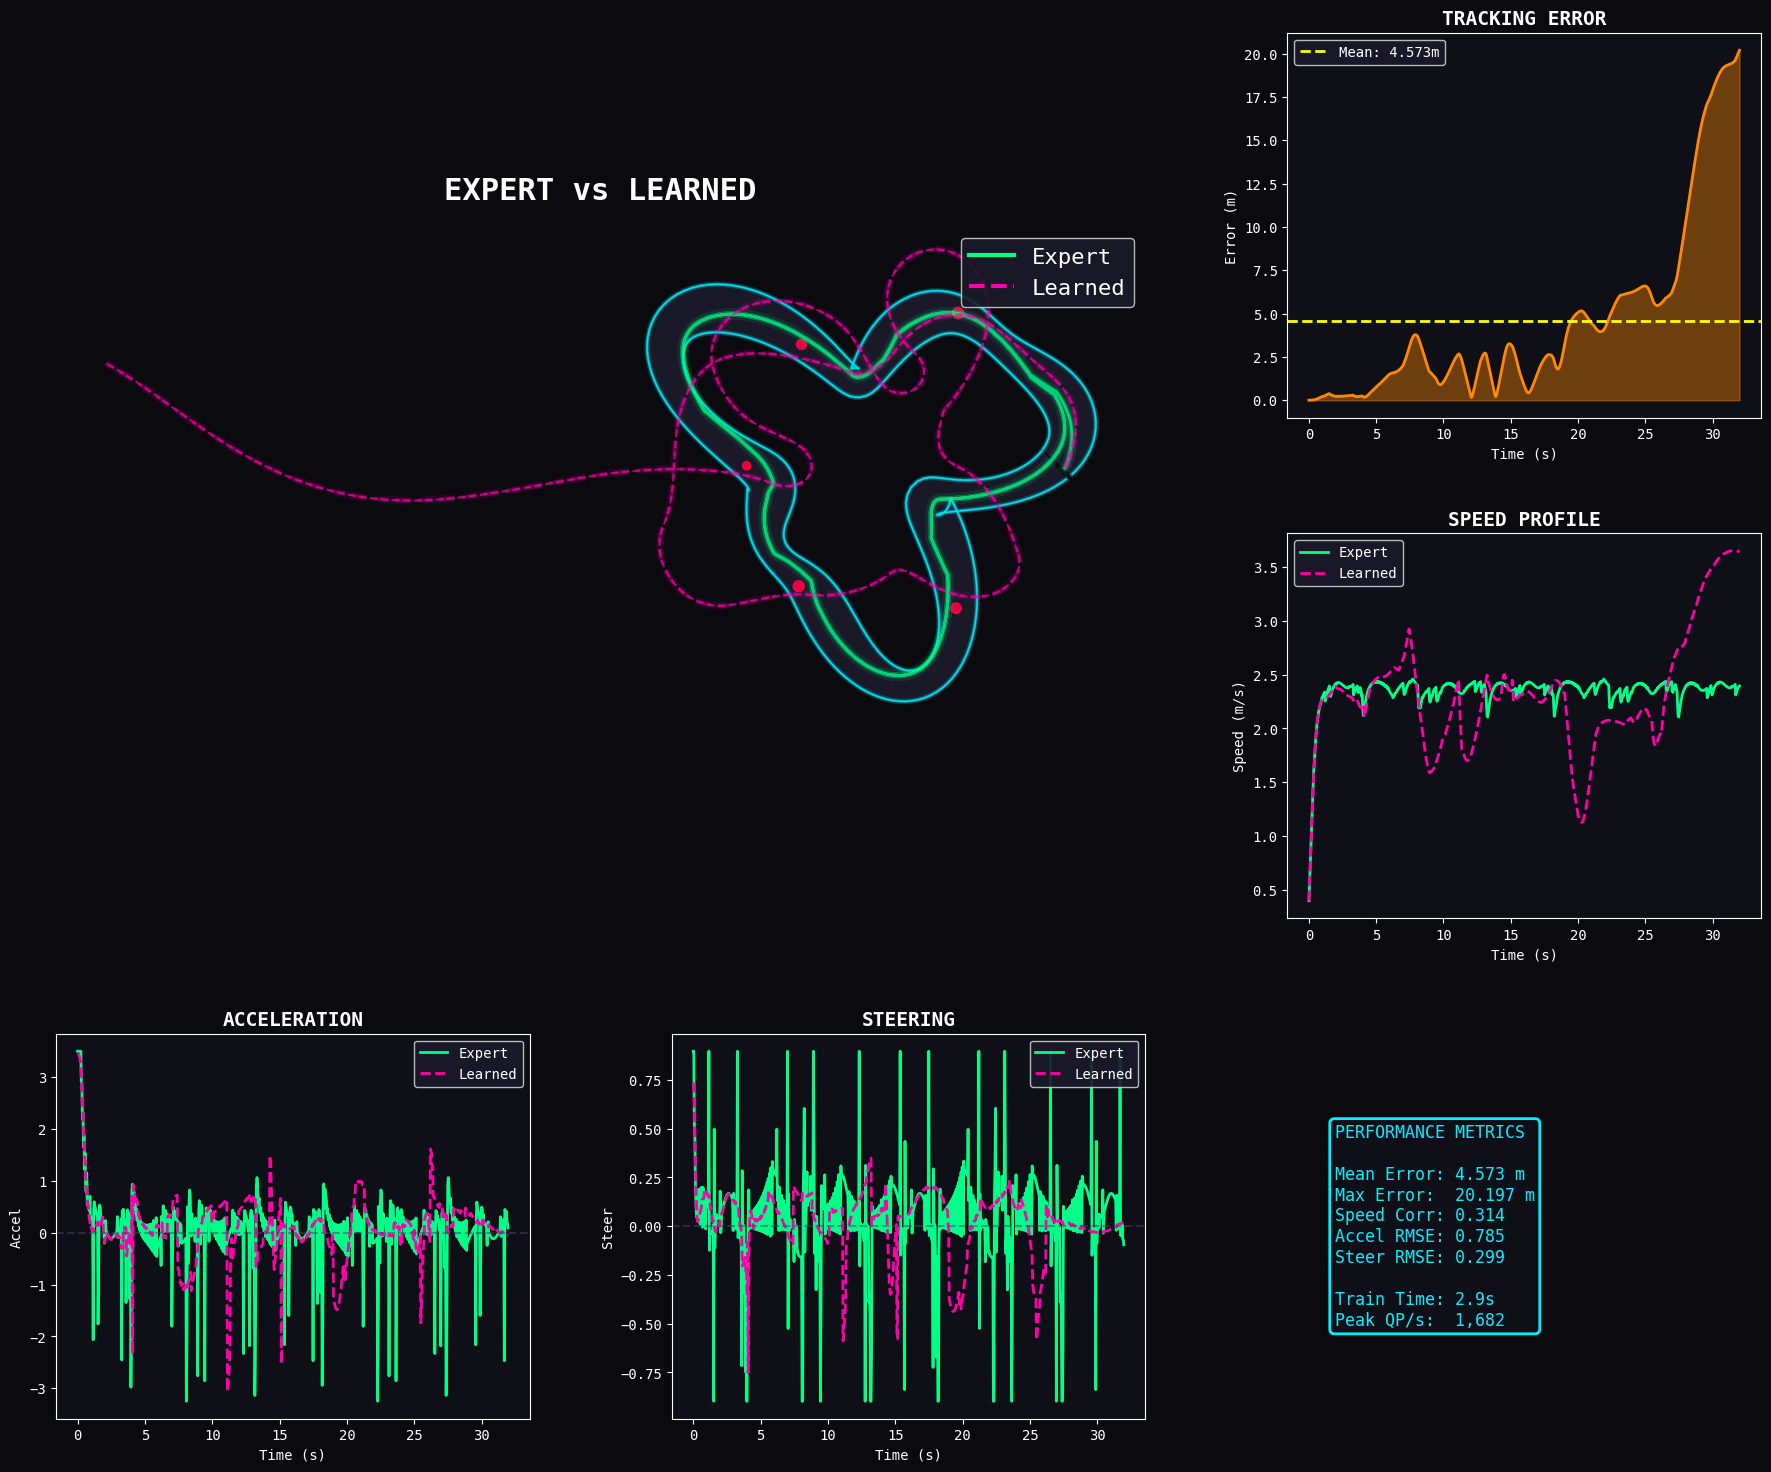

In [8]:
fig = plt.figure(figsize=(22, 18))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

ax = fig.add_subplot(gs[:2, :2])
poly = np.vstack([track.outer_boundary, track.inner_boundary[::-1]])
ax.fill(poly[:, 0], poly[:, 1], color='#1a1a2a', alpha=0.95)
for w, a in [(4, 0.2), (2, 0.5), (1, 0.8)]:
    ax.plot(track.inner_boundary[:, 0], track.inner_boundary[:, 1], color=C['blue'], lw=w, alpha=a)
    ax.plot(track.outer_boundary[:, 0], track.outer_boundary[:, 1], color=C['blue'], lw=w, alpha=a)
for w, a in [(8, 0.1), (4, 0.3), (2, 0.7)]:
    ax.plot(exp_data['states'][:, 0], exp_data['states'][:, 1], color=C['green'], lw=w, alpha=a)
for w, a in [(6, 0.1), (3, 0.3), (1.5, 0.7)]:
    ax.plot(learned['states'][:, 0], learned['states'][:, 1], color=C['pink'], lw=w, alpha=a, ls='--')
for x, y, r in track.obstacles:
    ax.add_patch(Circle((x, y), r, color=C['red'], alpha=0.9))
ax.set_aspect('equal'); ax.axis('off')
ax.set_title('EXPERT vs LEARNED', fontsize=22, fontweight='bold', color=C['white'], pad=20)
ax.legend([plt.Line2D([0],[0], color=C['green'], lw=3), plt.Line2D([0],[0], color=C['pink'], lw=3, ls='--')], ['Expert', 'Learned'], fontsize=16, framealpha=0.9, facecolor='#1a1a2a', loc='upper right')

n = min(len(exp_data['states']), len(learned['states']))
errors = np.linalg.norm(exp_data['states'][:n, :2] - learned['states'][:n, :2], axis=1)
t = np.arange(n) * dyn.dt

ax = fig.add_subplot(gs[0, 2])
ax.fill_between(t, 0, errors, color=C['orange'], alpha=0.4)
ax.plot(t, errors, color=C['orange'], lw=2)
ax.axhline(errors.mean(), color=C['yellow'], ls='--', lw=2, label=f'Mean: {errors.mean():.3f}m')
ax.set_xlabel('Time (s)'); ax.set_ylabel('Error (m)')
ax.set_title('TRACKING ERROR', fontsize=14, fontweight='bold', color=C['white'])
ax.legend(framealpha=0.9, facecolor='#1a1a2a')

ax = fig.add_subplot(gs[1, 2])
ax.plot(t, exp_data['states'][:n, 3], color=C['green'], lw=2, label='Expert')
ax.plot(t, learned['states'][:n, 3], color=C['pink'], lw=2, ls='--', label='Learned')
ax.set_xlabel('Time (s)'); ax.set_ylabel('Speed (m/s)')
ax.set_title('SPEED PROFILE', fontsize=14, fontweight='bold', color=C['white'])
ax.legend(framealpha=0.9, facecolor='#1a1a2a')

nc = min(len(exp_data['controls']), len(learned['controls']))
tc = np.arange(nc) * dyn.dt

ax = fig.add_subplot(gs[2, 0])
ax.plot(tc, exp_data['controls'][:nc, 0], color=C['green'], lw=2, label='Expert')
ax.plot(tc, learned['controls'][:nc, 0], color=C['pink'], lw=2, ls='--', label='Learned')
ax.axhline(0, color=C['gray'], ls='--', alpha=0.5)
ax.set_xlabel('Time (s)'); ax.set_ylabel('Accel')
ax.set_title('ACCELERATION', fontsize=14, fontweight='bold', color=C['white'])
ax.legend(framealpha=0.9, facecolor='#1a1a2a')

ax = fig.add_subplot(gs[2, 1])
ax.plot(tc, exp_data['controls'][:nc, 1], color=C['green'], lw=2, label='Expert')
ax.plot(tc, learned['controls'][:nc, 1], color=C['pink'], lw=2, ls='--', label='Learned')
ax.axhline(0, color=C['gray'], ls='--', alpha=0.5)
ax.set_xlabel('Time (s)'); ax.set_ylabel('Steer')
ax.set_title('STEERING', fontsize=14, fontweight='bold', color=C['white'])
ax.legend(framealpha=0.9, facecolor='#1a1a2a')

ax = fig.add_subplot(gs[2, 2])
ax.axis('off')
speed_corr = np.corrcoef(exp_data['states'][:n, 3], learned['states'][:n, 3])[0, 1]
accel_rmse = np.sqrt(((exp_data['controls'][:nc, 0] - learned['controls'][:nc, 0])**2).mean())
steer_rmse = np.sqrt(((exp_data['controls'][:nc, 1] - learned['controls'][:nc, 1])**2).mean())
metrics = f"""PERFORMANCE METRICS\n\nMean Error: {errors.mean():.3f} m\nMax Error:  {errors.max():.3f} m\nSpeed Corr: {speed_corr:.3f}\nAccel RMSE: {accel_rmse:.3f}\nSteer RMSE: {steer_rmse:.3f}\n\nTrain Time: {train_time:.1f}s\nPeak QP/s:  {peak_qps:,.0f}"""
ax.text(0.1, 0.5, metrics, fontfamily='monospace', fontsize=12, color=C['blue'], verticalalignment='center', bbox=dict(boxstyle='round', facecolor='#0f0f18', edgecolor=C['blue'], lw=2))
plt.savefig('racing_comparison.png', dpi=150, bbox_inches='tight', facecolor='#0a0a0f')
plt.show()

## 6. Animation

Creating animation...


Saved racing_animation.gif


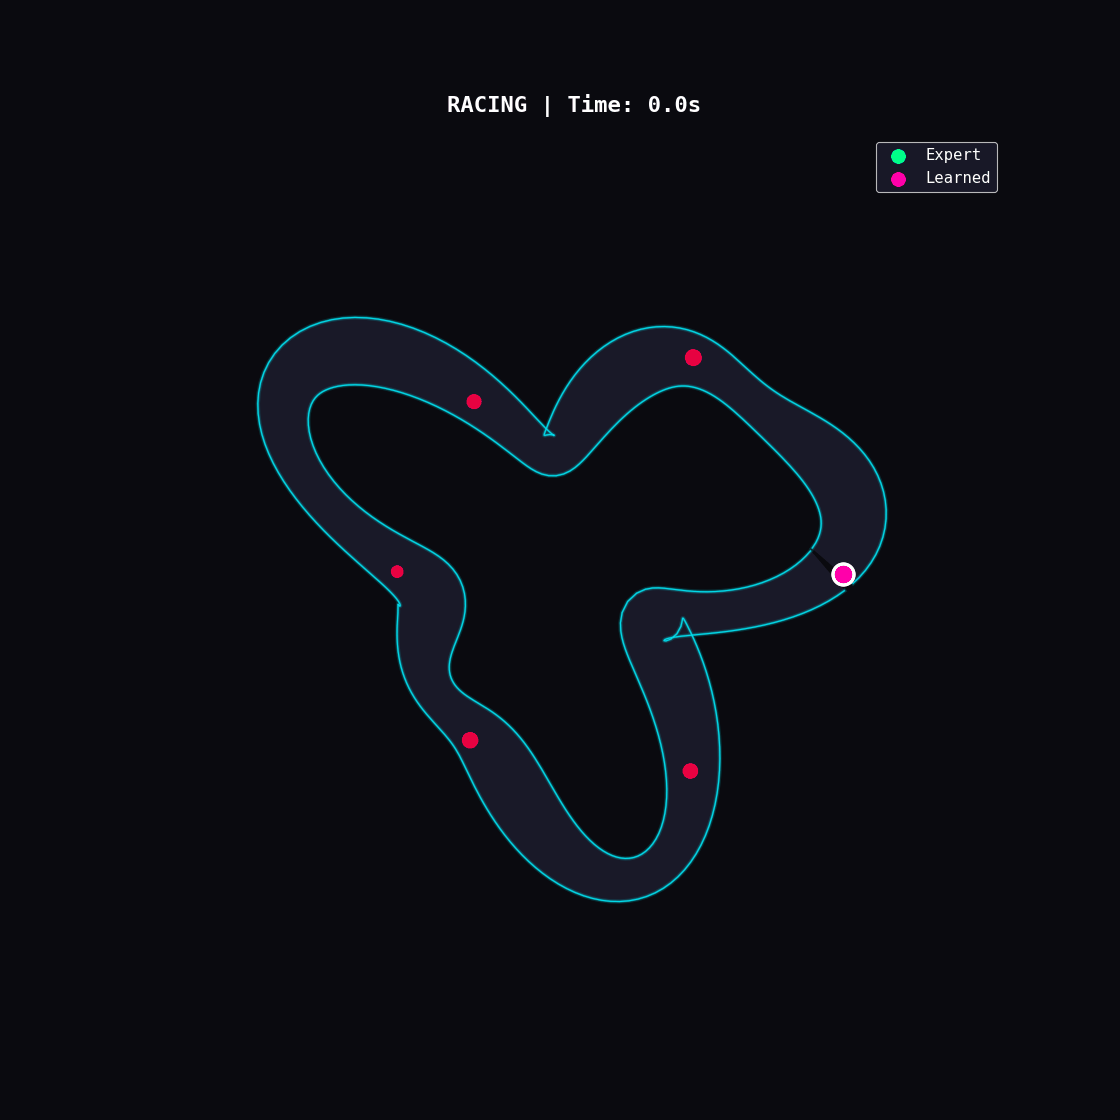

In [9]:
def make_animation(exp, lrn, track, frames=150, trail=35):
    fig, ax = plt.subplots(figsize=(14, 14))
    poly = np.vstack([track.outer_boundary, track.inner_boundary[::-1]])
    ax.fill(poly[:, 0], poly[:, 1], color='#1a1a2a', alpha=0.95)
    for w, a in [(4, 0.15), (2, 0.4), (1, 0.8)]:
        ax.plot(track.inner_boundary[:, 0], track.inner_boundary[:, 1], color=C['blue'], lw=w, alpha=a)
        ax.plot(track.outer_boundary[:, 0], track.outer_boundary[:, 1], color=C['blue'], lw=w, alpha=a)
    for x, y, r in track.obstacles:
        ax.add_patch(Circle((x, y), r, color=C['red'], alpha=0.9, zorder=5))
    ax.set_aspect('equal'); ax.set_xlim(-8, 8); ax.set_ylim(-8, 8); ax.axis('off')
    
    exp_trail, = ax.plot([], [], color=C['green'], lw=5, alpha=0.7)
    lrn_trail, = ax.plot([], [], color=C['pink'], lw=5, alpha=0.7)
    exp_glow, = ax.plot([], [], color=C['green'], lw=12, alpha=0.2)
    lrn_glow, = ax.plot([], [], color=C['pink'], lw=12, alpha=0.2)
    exp_car = ax.scatter([], [], s=350, c=C['green'], zorder=10, edgecolors='white', lw=3)
    lrn_car = ax.scatter([], [], s=350, c=C['pink'], zorder=10, edgecolors='white', lw=3)
    title = ax.set_title('', fontsize=20, fontweight='bold', color=C['white'], pad=20)
    ax.scatter([], [], s=150, c=C['green'], label='Expert')
    ax.scatter([], [], s=150, c=C['pink'], label='Learned')
    ax.legend(loc='upper right', fontsize=14, framealpha=0.9, facecolor='#1a1a2a')
    
    step = max(1, len(exp) // frames)
    def animate(f):
        i = min(f * step, len(exp) - 1)
        s = max(0, i - trail)
        exp_trail.set_data(exp[s:i+1, 0], exp[s:i+1, 1])
        lrn_trail.set_data(lrn[s:i+1, 0], lrn[s:i+1, 1])
        exp_glow.set_data(exp[s:i+1, 0], exp[s:i+1, 1])
        lrn_glow.set_data(lrn[s:i+1, 0], lrn[s:i+1, 1])
        exp_car.set_offsets([[exp[i, 0], exp[i, 1]]])
        lrn_car.set_offsets([[lrn[i, 0], lrn[i, 1]]])
        title.set_text(f'RACING | Time: {i*dyn.dt:.1f}s')
        return exp_trail, lrn_trail, exp_glow, lrn_glow, exp_car, lrn_car, title
    
    anim = FuncAnimation(fig, animate, frames=frames, interval=40, blit=True)
    plt.close()
    return anim

print('Creating animation...')
anim = make_animation(exp_data['states'], learned['states'], track, frames=180, trail=40)
anim.save('racing_animation.gif', writer='pillow', fps=25, dpi=80)
print('Saved racing_animation.gif')

from IPython.display import Image
Image(filename='racing_animation.gif')

In [10]:
print('='*70)
print('  LEARN TO RACE COMPLETE!')
print('='*70)
print(f'  Track: {len(track.centerline)} pts, {len(track.obstacles)} obstacles')
print(f'  Expert: {len(exp_data["states"])} samples')
print(f'  Model: {sum(p.numel() for p in model.parameters()):,} params')
print(f'  Training: {train_time:.1f}s, {n_epochs} epochs')
print(f'  Error: {errors.mean():.3f}m mean, {errors.max():.3f}m max')
print(f'  Speed: {speed_corr:.3f} correlation')
print(f'  GPU: {peak_qps:,.0f} QPs/sec')
print('='*70)
print('  Files: racing_track.png, expert_demo.png, gpu_benchmark.png,')
print('         training_curves.png, racing_comparison.png, racing_animation.gif')
print('='*70)

  LEARN TO RACE COMPLETE!
  Track: 300 pts, 5 obstacles
  Expert: 801 samples
  Model: 105,602 params
  Training: 2.9s, 300 epochs
  Error: 4.573m mean, 20.197m max
  Speed: 0.314 correlation
  GPU: 1,682 QPs/sec
  Files: racing_track.png, expert_demo.png, gpu_benchmark.png,
         training_curves.png, racing_comparison.png, racing_animation.gif
